# Protein Secondary Structure Prediction

## Introduction
In this project, we aim to predict the secondary structure of proteins using deep learning techniques. Protein secondary structure prediction is an important task in bioinformatics as it provides insights into the spatial arrangement of amino acids, which is crucial for understanding protein function and folding.

**Name**: Aaditya Poonia
**University ID**: 2907407P

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import matplotlib.pyplot as plt

!pip install ax-platform
from ax.service.ax_client import AxClient, ObjectiveProperties 

random_seed = 42

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2

[WARNING 03-17 11:40:42] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


## 1. Data Loading and Preprocessing
We load the protein sequence data and corresponding secondary structure labels from CSV files. Preprocessing steps include merging the dataframes, loading PSSM profiles, and encoding labels.

In [2]:
seqs_train = pd.read_csv("/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv")
labels_train = pd.read_csv("/kaggle/input/deep-learning-for-msc-202324/labels_train.csv")
 
# Merge the dataframes on PDB_ID
train_data = pd.merge(seqs_train, labels_train, on="PDB_ID")
 
pssm_label_train_data = []
for file in train_data['PDB_ID']:
    path = f"/kaggle/input/deep-learning-for-msc-202324/train/{file}_train.csv"
    pssm_df = pd.read_csv(path)
    label = labels_train[labels_train['PDB_ID'] == file]
    label_array = np.array(list(label['SEC_STRUCT'].iloc[0]))
    new_labels = pd.DataFrame({'Secondary_Structure_Array': label_array})
    pssm_with_labels = pd.concat([pssm_df, new_labels], axis=1)
    pssm_label_train_data.append(pssm_with_labels)

In [ ]:
# Testing the data file
sample = pssm_label_train_data[10]
sample

,RES_NUM,AMINO_ACID,A,C,D,E,F,G,H,I,...,N,P,Q,R,S,T,V,W,Y,Secondary_Structure_Array
0,1,V,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.617732,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382268,0.00000,0.000000,C
1,2,T,0.005941,0.000000,0.006556,0.007785,0.000000,0.014136,0.000000,0.000000,...,0.064536,0.016185,0.004098,0.026839,0.240934,0.583077,0.000000,0.00000,0.000000,C
2,3,I,0.054317,0.001592,0.002477,0.005839,0.010262,0.000000,0.013623,0.415074,...,0.000000,0.191791,0.000000,0.000000,0.003539,0.014331,0.177459,0.00000,0.004069,H
3,4,D,0.084696,0.000000,0.306397,0.346721,0.000000,0.032874,0.001296,0.003239,...,0.001296,0.022348,0.041457,0.021377,0.051336,0.014413,0.002591,0.00000,0.004049,H
4,5,N,0.063786,0.009972,0.143875,0.105413,0.038462,0.056189,0.007123,0.023109,...,0.177430,0.000000,0.050807,0.050649,0.023267,0.062362,0.007439,0.00000,0.024058,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,90,R,0.042782,0.000170,0.057269,0.037668,0.000170,0.038350,0.006818,0.004091,...,0.173172,0.000170,0.071416,0.221749,0.085222,0.028123,0.004091,0.00017,0.003238,H
90,91,T,0.011305,0.018586,0.014562,0.083733,0.006131,0.003832,0.021652,0.030274,...,0.037747,0.000000,0.075685,0.159034,0.040238,0.123204,0.013796,0.00000,0.010730,H
91,92,L,0.000000,0.000000,0.000000,0.000000,0.013360,0.000000,0.000000,0.422874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014372,0.00000,0.000000,H
92,93,S,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,C


## 2. Dataset Definition
We define a custom dataset class `ProteinStructureDataset` to handle the protein sequence data. The dataset loads PSSM profiles and encodes labels for model training.

In [4]:
class ProteinStructureDataset(Dataset):
    """Dataset for predicting protein secondary structure."""

    def __init__(self, pssm_label_train_data):
        self.pssm_label_train_data = pssm_label_train_data

    def __len__(self):
        return len(self.pssm_label_train_data)

    def __getitem__(self, idx):
        # Load PSSM profile
        data = pssm_label_train_data[idx]
        pssm_data = prepare_pssm_data(data)
        # Load secondary structure labels
        labels = data.iloc[:,-1]
        labels = encode_labels(labels)

        return pssm_data, labels

def prepare_pssm_data(df):
    """Prepares the PSSM data for model training."""
    df = df.iloc[:, 2:-1].astype(float)
    return df.to_numpy()


def encode_labels(sequence):
    encoding = np.zeros((len(sequence), 3))
    label_map = {'C': 0, 'E': 1, 'H': 2}
    for i, amino in enumerate(sequence):
        encoding[i, label_map[amino]] = 1
    return encoding

In [5]:
# Testing the data loader
transformed_dataset = ProteinStructureDataset(pssm_label_train_data)
data,labels = transformed_dataset[10]
labels.shape

(94, 3)

## 3. Model Architecture
The neural network model `ProteinFCN` is a fully convolutional network designed to process PSSM profiles and predict secondary structure labels. The architecture consists of convolutional layers followed by ReLU activations and dropout for regularization.

In [25]:
class ProteinFCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=128, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=3, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)  # Applying dropout
        x = self.conv3(x)
        return x

## 4. Loss & Accuracy curves
Defining a function to create the loss and accuracy curves based on the training data

In [26]:
def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 5. Main Function

[INFO 03-17 14:12:32] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 03-17 14:12:32] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dropout_probability. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-17 14:12:32] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[0.0001, 0.01], log_scale=True), RangeParameter(name='dropout_probability', parameter_type=FLOAT, range=[0.0, 0.6])], parameter_constraints=[]).
[INFO 03-17 14:12:32] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 03-17 14:12:32] ax.modelbrid

Best parameters: {'lr': 0.0007556788127712358, 'dropout_probability': 0.17526682733872298}
Mean:  {'accuracy': 0.7830236572373299}  Covariance:  {'accuracy': {'accuracy': 1.3217890603235794e-07}}
Epoch 1/8: Train Loss=0.6320 Train Acc=0.7376 Val Loss=0.5543 Val Acc=0.7684
Epoch 2/8: Train Loss=0.5541 Train Acc=0.7695 Val Loss=0.5433 Val Acc=0.7763
Epoch 3/8: Train Loss=0.5334 Train Acc=0.7765 Val Loss=0.5267 Val Acc=0.7828
Epoch 4/8: Train Loss=0.5189 Train Acc=0.7808 Val Loss=0.5299 Val Acc=0.7794
Epoch 5/8: Train Loss=0.5069 Train Acc=0.7845 Val Loss=0.5190 Val Acc=0.7849
Epoch 6/8: Train Loss=0.4968 Train Acc=0.7871 Val Loss=0.5151 Val Acc=0.7876
Epoch 7/8: Train Loss=0.4877 Train Acc=0.7894 Val Loss=0.5247 Val Acc=0.7849
Epoch 8/8: Train Loss=0.4789 Train Acc=0.7918 Val Loss=0.5189 Val Acc=0.7858


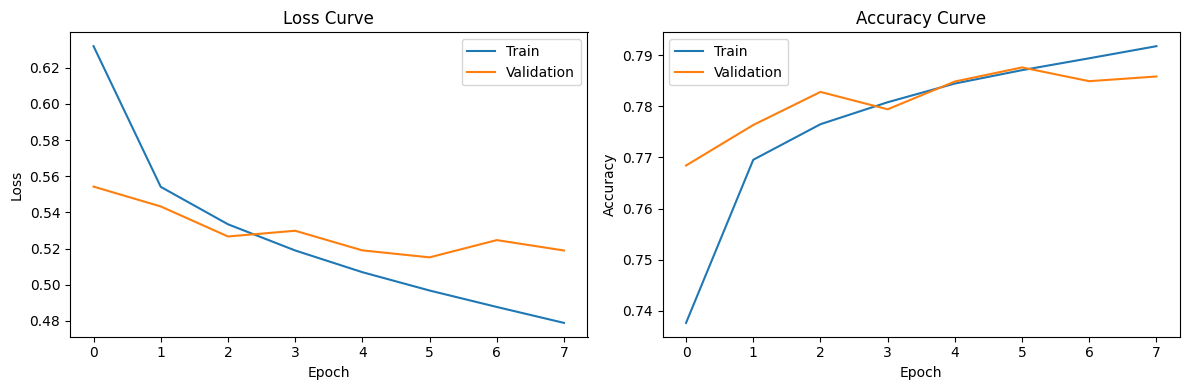

Trained model saved successfully!


In [27]:
# We implement the training loop to train the model using the dataset. The loop includes 
# forward and backward passes, optimization with Adam, and evaluation using cross-entropy loss.
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for data, labels in train_loader:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        data, labels = data.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output.permute(0, 2, 1)  # Reshape output tensor

        batch_loss = 0  # Accumulate loss for the entire batch
        for i in range(output.size(0)):
            # Get output and labels for current sequence
            seq_output = output[i]
            seq_labels = labels[i]
            
            loss = criterion(seq_output, seq_labels)
            batch_loss += loss  # Accumulate loss for the batch
            
            # Convert output to one-hot encoded predictions
            output_indices = torch.argmax(output.squeeze(), dim=-1)
            label_indices = torch.argmax(labels.squeeze(), dim=-1)

            # Compare the indices to check for correct predictions
            total_correct += torch.sum(output_indices == label_indices).item()
            total_samples += len(label_indices)

        batch_loss.backward()  # Perform backward pass for the entire batch
        optimizer.step()
        
        total_loss += batch_loss.item()
        
    train_accuracy = total_correct / total_samples

    return total_loss / len(train_loader), train_accuracy


# Evaluating the neural network model on the validation dataset
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, labels in val_loader:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            data, labels = data.to(device).float(), labels.to(device)
            output = model(data)
            output = output.permute(0, 2, 1)  # Reshape output tensor

            batch_size = output.size(0)
            for i in range(batch_size):
                # Get output and labels for current sequence
                seq_output = output[i]
                seq_labels = labels[i]
                
                # Calculate loss
                loss = criterion(seq_output, seq_labels)

                total_loss += loss.item()
                
                # Convert output to one-hot encoded predictions
                output_indices = torch.argmax(output.squeeze(), dim=-1)
                label_indices = torch.argmax(labels.squeeze(), dim=-1)

                # Compare the indices to check for correct predictions
                total_correct += torch.sum(output_indices == label_indices).item()
                total_samples += len(label_indices)

    val_accuracy = total_correct / total_samples

    return total_loss / len(val_loader), val_accuracy


# Executing main function
def main():
    ax_client = AxClient()
    
    # Define hyperparameters
    batch_size = 1
    validation_split = 0.2   # To be used to create validation data = 20 % of training data
    num_epochs = 8

    # Define dataset and data loaders and dividing traininf data into training and validation data
    dataset = ProteinStructureDataset(pssm_label_train_data)
    dataset_size = len(dataset)
    val_size = int(np.floor(validation_split * dataset_size))
    train_size = dataset_size - val_size
    train_data, val_data = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()   # Loss function being used for the model
    
    # Hyperparameter Optimization :-
    # We use the Ax platform for hyperparameter optimization. Parameters such as 
    # learning rate and dropout probability are optimized to improve model performance
    
    ax_client.create_experiment(
        name="protein_secondary_seq",  # The name of the experiment.
        parameters=[
            {
                "name": "lr",  # The name of the parameter.
                "type": "range",  
                "bounds": [1e-4, 0.01],  # The bounds for range parameters
                "value_type": "float",  
                "log_scale": True,  
            },
            {
                "name": "dropout_probability",  # The name of the parameter.
                "type": "range",
                "bounds": [0.0, 0.6],  # The bounds for range parameters
            },
        ],
        objectives={"accuracy": ObjectiveProperties(minimize=False)},  # The objective name and minimization setting.
        )
    
    # Trains and evaluates the neural network to get the best hyperparameter values
    def train_evaluate(parameters, train_loader, val_loader, criterion):
        # Extract parameters
        learning_rate = parameters["lr"]
        dropout_probability = parameters["dropout_probability"]
        num_epochs = 8
        
        model = ProteinFCN()
        model.dropout.p = dropout_probability
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        val_accuracies = []
        # Train and evaluate
        for epoch in range(num_epochs):
            train(model, train_loader, optimizer, criterion)
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            val_accuracies.append(val_accuracy)  # Append accuracy for this epoch

        # Return the average validation accuracy over all epochs
        return sum(val_accuracies) / len(val_accuracies)
    
    # Attach the trial
    ax_client.attach_trial(
        parameters={"lr": 0.001,"dropout_probability": 0.2}
    )

    # Getting the parameters and running the trial
    baseline_parameters = ax_client.get_trial_parameters(trial_index=0)
    ax_client.complete_trial(trial_index=0, raw_data=train_evaluate(baseline_parameters,train_loader, val_loader, criterion))
    
    for i in range(15):
        parameters, trial_index = ax_client.get_next_trial()
        ax_client.complete_trial(trial_index=trial_index, raw_data=train_evaluate(parameters,train_loader, val_loader, criterion))
    
    best_parameters, values = ax_client.get_best_parameters()
    mean, covariance = values

    # Print the best parameters found
    print("Best parameters:", best_parameters)
    print("Mean: ", mean," Covariance: ",covariance)

    # Train the model with the best parameters
    learning_rate =  best_parameters['lr']  
    dropout_probability =  best_parameters['dropout_probability']  

    # Initialize model, optimizer, and loss function
    model = ProteinFCN()
    model.dropout.p = dropout_probability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer for updating model parameters

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    plot_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save trained model
    torch.save(model.state_dict(), "trained_model.pt")
    print("Trained model saved successfully!")

if __name__ == "__main__":
    main()

## 6. Testing and Prediction
We evaluate the trained model on a test dataset and make predictions on unseen protein sequences. Performance metrics are calculated, and predictions are saved to a CSV file for submission.

In [28]:
class TestProteinStructureDataset(Dataset):
    """Dataset for predicting protein secondary structure."""
    def __init__(self, seqs_csv, data_dir):
        self.seqs = pd.read_csv(seqs_csv)
        self.data_dir = data_dir

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        pdb_id = self.seqs.iloc[idx, 0]
        pssm_file_path = f"{self.data_dir}/{pdb_id}_test.csv"
        pssm_df = load_pssm_data(pssm_file_path)
        pssm_data = prepare_test_pssm_data(pssm_df)
        return pdb_id, pssm_data

def load_pssm_data(data_path):
    """Loads PSSM data from a CSV file into a pandas DataFrame."""
    df = pd.read_csv(data_path)
    return df
    
def prepare_test_pssm_data(df):
    """Prepares the PSSM data for model training."""
    df = df.iloc[:, 2:].astype(float)
    return df.to_numpy()    
    
def test(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for pdb_id_tuple, data in test_loader:
            pdb_id = pdb_id_tuple[0]  # Extracting the string from the tuple
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            data = data.to(device).float()
            output = model(data)
            output = output.permute(0, 2, 1)  # Changing shape of output to match with labels shape

            output_indices = torch.argmax(output.squeeze(), dim=-1)  # Removing batch dimension and taking index of maximum value
            pred_sequence = map_indices_to_labels(output_indices)

            for i, label in enumerate(pred_sequence):
                predictions.append((f"{pdb_id}_{i+1}", label))

    return predictions


def map_indices_to_labels(indices):
    # Define the mapping from indices to secondary structure labels
    label_map = {0: 'C', 1: 'E', 2: 'H'}
    pred_sequence = [label_map[idx.item()] for idx in indices]
    return pred_sequence


def test_main():
    # Load trained model
    model = ProteinFCN()
    model.load_state_dict(torch.load("trained_model.pt"))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load test dataset
    test_dataset = TestProteinStructureDataset("/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv", "/kaggle/input/deep-learning-for-msc-202324/test/")
    test_loader = DataLoader(test_dataset, batch_size=1)

    # Make predictions on test data
    predictions = test(model, test_loader)

    # Save predictions to CSV
    df = pd.DataFrame(predictions, columns=["ID", "STRUCTURE"])
    
    df.to_csv("submission.csv", index=False)

    print("Predictions saved to submission.csv")
    
    print(df.head(10))

if __name__ == "__main__":
    test_main()


Predictions saved to submission.csv
            ID STRUCTURE
0   2AIO_1_A_1         C
1   2AIO_1_A_2         C
2   2AIO_1_A_3         C
3   2AIO_1_A_4         C
4   2AIO_1_A_5         C
5   2AIO_1_A_6         H
6   2AIO_1_A_7         H
7   2AIO_1_A_8         H
8   2AIO_1_A_9         H
9  2AIO_1_A_10         H


## 7. Results and Conclusion:

From the provided results and the loss/accuracy graph for training and validation data per epoch, we can infer the following about the model:

Best Parameters: The best hyperparameters found during the optimization process were a learning rate (lr) of approximately 0.00076 and a dropout probability of around 0.175.

Mean Accuracy: The mean accuracy achieved by the model across different hyperparameter configurations is approximately 78.3%.

Epoch-wise Training and Validation:

Epoch 1: The training accuracy starts at 73.76% and validation accuracy at 76.84%. Both training and validation losses are relatively high.
Epoch 2 to 5: Both training and validation accuracies show an increasing trend, indicating that the model is learning from the data. The losses decrease over these epochs, suggesting improved performance.
Epoch 6 to 8: The training and validation accuracies continue to increase, albeit at a slower rate. The losses stabilize around epoch 6, indicating that the model is converging.
Validation Accuracy: The validation accuracy reaches its peak around epoch 6 at approximately 78.76% and remains relatively stable thereafter, indicating that the model has learned to generalize well to unseen data.

Overall, the training process seems to be going well, with the model showing improvement in both training and validation accuracies over the epochs. The validation accuracy plateauing suggests that the model may have reached its optimal performance given the current architecture and hyperparameters. 